<a href="https://colab.research.google.com/github/ArtemChemist/CFU_counter/blob/HoughwThresholding/Baseline_CNN_and_RF_on_224dpi_nothresh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
from datetime import datetime
import time

import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers.normalization import batch_normalization
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop

from sklearn.model_selection import train_test_split


In [2]:
# Set up folder
SIZE = 224 #Size of the images this model will deal with
IMDIM = 3
Filters = 16
BATCH_SIZE = 32
EPOCHS = 100
TEST_SIZE = 0.3   # Validation/Train split ratio
RAND_SEED  = 42 # The answer to the ultimate question of life, the universe, and everything   
ACCURACY_THRESHOLD = 0.9           # Set the desired accuracy threshold
IMG_SIZE = (SIZE, SIZE)            # Define the image size
INPUT_SHAPE = (*IMG_SIZE, IMDIM)       # Define the input_shape
num_classes = 2  # Number of clases for prediction

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/My Drive/224_nothresh.zip" -d "/content"

Archive:  /content/drive/My Drive/224_nothresh.zip
   creating: /content/224_nothresh/
  inflating: /content/224_nothresh/6c17ffdf996199dd1ad6b9a973db0857-127-0.jpg  
  inflating: /content/224_nothresh/543dbc657725f7f189ee5cd6005889bc-100-0.jpg  
  inflating: /content/224_nothresh/2c62c5c8671549a731e2eb049ca5e31f-103-0.jpg  
  inflating: /content/224_nothresh/a58a4ca2b656f6463c9b9765495eb97d-127-0.jpg  
  inflating: /content/224_nothresh/24e053c4e8ec4ebf2fe57e9bbd09626f-79-0.jpg  
  inflating: /content/224_nothresh/3c8d7a89d58ef4508ded25721a770cfe-119-0.jpg  
  inflating: /content/224_nothresh/4088772371dffd56986bad40ec63a5cb-265-0.jpg  
  inflating: /content/224_nothresh/852d5510bf2c1d40db3d614d3f7d34ed-268-0.jpg  
  inflating: /content/224_nothresh/503cb636a3d2bafd275efd7c4ffc9dc5-209-0.jpg  
  inflating: /content/224_nothresh/5ed142b6b00e17680e98bba1e18333a4-68-0.jpg  
  inflating: /content/224_nothresh/3ea01a56492b44f7f28b1fbb76136f84-211-0.jpg  
  inflating: /content/224_nothresh/

In [5]:
# Set up folder, unless it is already set up
p = os.path.abspath('.')
input_dir = os.path.join(p, f'{SIZE}_nothresh')

# Read filenames in the folder
image_names = []
labels = []

for file in glob.glob(f'{input_dir}/*.jpg'):
	filename = file.split('/')[-1]
	num_colonies = int(filename.split('-')[2].strip().split('.')[0])
	if num_colonies == 0:
		labels.append(0)
	else:
		labels.append(1)
	image_names.append(filename)

X_files = np.array(image_names) #  Array with image nbames
y = np.array(labels)			#  Array with binary labels

print(f'Full dataset: {np.sum(y)} images with bacteria and {len(y)-np.sum(y)} without')

Full dataset: 324 images with bacteria and 3479 without


In [6]:
# Now shuffle the names
print("Suffling the dataset ....")
num_datapoints = X_files.shape[0]
indices = np.arange(num_datapoints)
shuffled_indices = np.random.permutation(indices)
X_shuffled_files = X_files[shuffled_indices]
y_shuffled = y[shuffled_indices]

# Read the actual files
print("Reading actual images...")
images = []
for file_name in X_shuffled_files:
    file = os.path.join(input_dir, file_name)
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    images.append(img)

X_shuffled = np.array(images) # Shuffled dataset
#  Make array shape compatible with keras Conv2D layers
X_shuffled = X_shuffled.reshape(X_shuffled.shape[0], X_shuffled.shape[1], X_shuffled.shape[2], 3)
X_shuffled = X_shuffled.astype(np.float32)/255 # Scale all images


Suffling the dataset ....
Reading actual images...


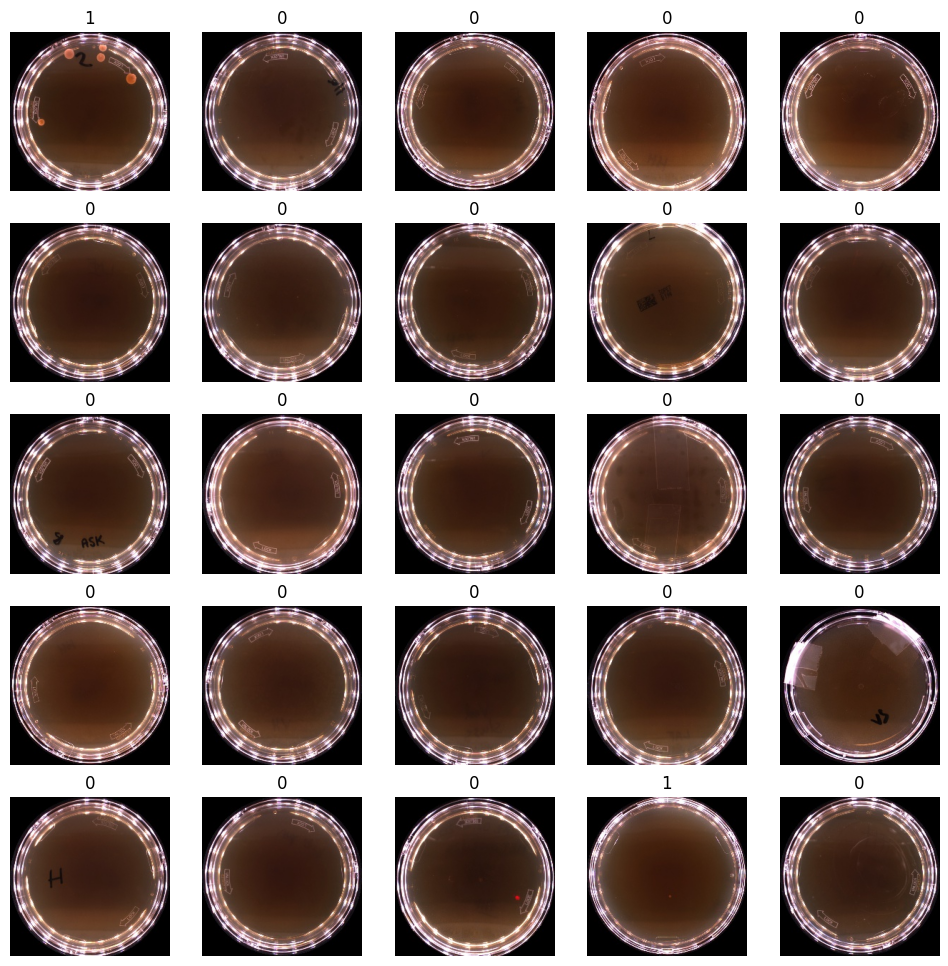

In [7]:
# Visualize random 25 images to make sure it makes sense
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = np.random.choice(np.arange(len(y_shuffled)))
    image = X_shuffled[idx]
    axs[i,j].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[i,j].set_title(y_shuffled[idx])
    axs[i,j].axis('off')

plt.show()

In [8]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

def prepare_data(X_shuffled, y_shuffled, test_size=TEST_SIZE, random_state=RAND_SEED):
    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_shuffled, y_shuffled, test_size=test_size, random_state=random_state)

    # Convert labels to integers
    y_train = y_train.astype(int)
    y_val = y_val.astype(int)

    # One-hot encode the labels
    num_classes = max(np.max(y_train), np.max(y_val)) + 1
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_val = to_categorical(y_val, num_classes=num_classes)

    return X_train, X_val, y_train, y_val

def evaluate_model(model, history, X_val, y_val, plot_target = False):
    # Evaluate the model
    y_true = np.argmax(y_val, axis=1)
    y_pred = model.predict(X_val)

    y_pred_dense = np.argmax(y_pred, axis=1)
    f1 = f1_score(y_true, y_pred_dense, average='weighted')
    accuracy = accuracy_score(y_true, y_pred_dense)
    recall = recall_score(y_true, y_pred_dense)

    # Convergence time
    convergence = history.history['loss'][-1]

    #Plot confusion matrics
    cm = confusion_matrix(y_true, y_pred_dense)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [f'{value}' for value in cm.flatten()]
    group_percentages = [f'{value:.2f}' for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')

    #Plot precision and recall
    display = PrecisionRecallDisplay.from_predictions(y_true, y_pred[:,1], name="CNN Model")
    _ = display.ax_.set_title("Precision-Recall curve")
    _ = display.ax_.set_xlim(0,1)
    _ = display.ax_.set_ylim(0,1)
    _ = display.ax_.spines['top'].set_visible(False)
    _ = display.ax_.spines['right'].set_visible(False)
    if plot_target:
      _ = display.ax_.fill_between([0.99,1], [0.3,0.3], [1,1], facecolor = 'green', alpha=.5)

    return f1, accuracy, convergence, recall

def evaluate_RF_model(model, X_val, y_val):
    y_true = np.argmax(y_val, axis=1)
    y_pred_dense = np.argmax(model.predict(X_val), axis=1)
    f1 = f1_score(y_true, y_pred_dense, average='weighted')
    accuracy = accuracy_score(y_true, y_pred_dense)

    #Plot confusion matrics
    cm = confusion_matrix(y_true, y_pred_dense)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [f'{value}' for value in cm.flatten()]
    group_percentages = [f'{value:.2f}' for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')

    f1 = f1_score(y_true, y_pred_dense, average='weighted')
    accuracy = accuracy_score(y_true, y_pred_dense)
    recall = recall_score(y_true, y_pred_dense)

    return f1, accuracy, recall


In [9]:
# prepare data
X_train, X_val, y_train, y_val = prepare_data(X_shuffled, y_shuffled)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
def make_conv_layers(input_shape):

    conv_layers = Sequential()

    # Zero'th convolutional layer
    conv_layers.add(Conv2D(16, (7, 7), activation='relu', input_shape=input_shape))
    conv_layers.add(batch_normalization.BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # First convolutional layer
    conv_layers.add(Conv2D(32, (9, 9), activation='relu'))
    conv_layers.add(batch_normalization.BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer
    conv_layers.add(Conv2D(64, (11, 11), activation='relu'))
    conv_layers.add(batch_normalization.BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional layer
    conv_layers.add(Conv2D(128, (13, 13), activation='relu'))
    conv_layers.add(batch_normalization.BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    conv_layers.add(Flatten())

    return conv_layers

def create_cnn_model(conv_layers, num_classes):
    conv_layers.add(Dense(512, activation='relu'))
    conv_layers.add(Dropout(0.5))
    conv_layers.add(Dense(num_classes, activation='softmax'))
    return conv_layers

In [11]:
#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

# Define the CNN model
# Make it so that we would have a pointer to convolutional layers
conv_layers = make_conv_layers(INPUT_SHAPE)
cnn_model = create_cnn_model(conv_layers, num_classes)

# Compile the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f21533f87c0>>

In [12]:
# Train the model with the early stopping callback
start_time = time.time()
cnn_history = cnn_model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, callbacks=[early_stopping])
end_time = time.time()

print(f"Time taken: {end_time - start_time:.2f} seconds")

Epoch 1/100
84/84 [==============================] - 21s 81ms/step - loss: 0.5673 - accuracy: 0.8952 - val_loss: 1.4433 - val_accuracy: 0.9115
Epoch 2/100
84/84 [==============================] - 5s 57ms/step - loss: 0.3206 - accuracy: 0.9121 - val_loss: 0.8969 - val_accuracy: 0.9115
Epoch 3/100
84/84 [==============================] - 5s 58ms/step - loss: 0.2733 - accuracy: 0.9222 - val_loss: 0.9991 - val_accuracy: 0.9115
Epoch 4/100
84/84 [==============================] - 5s 58ms/step - loss: 0.2370 - accuracy: 0.9320 - val_loss: 0.5514 - val_accuracy: 0.7371
Epoch 5/100
84/84 [==============================] - 5s 58ms/step - loss: 0.1934 - accuracy: 0.9459 - val_loss: 0.3442 - val_accuracy: 0.9299
Epoch 6/100
84/84 [==============================] - 5s 58ms/step - loss: 0.3119 - accuracy: 0.9309 - val_loss: 1.1500 - val_accuracy: 0.9132
Epoch 7/100
84/84 [==============================] - 5s 58ms/step - loss: 0.2149 - accuracy: 0.9395 - val_loss: 0.3589 - val_accuracy: 0.9316
Epoch

In [13]:
# Set up folder, unless it is already set up
now = datetime.now() # current date and time

date_time = now.strftime("%m-%d-%Y-%H-%M")
p = os.path.abspath('.')
model_dir = os.path.join(p, "drive", "MyDrive", f'baseline_CNN_on_{SIZE}dpi')
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    print(f"{model_dir} created")
else:
    print(f"{model_dir} already exists")
    model_dir = model_dir+date_time

cnn_model.save(model_dir)


/content/drive/MyDrive/baseline_CNN_on_224dpi already exists


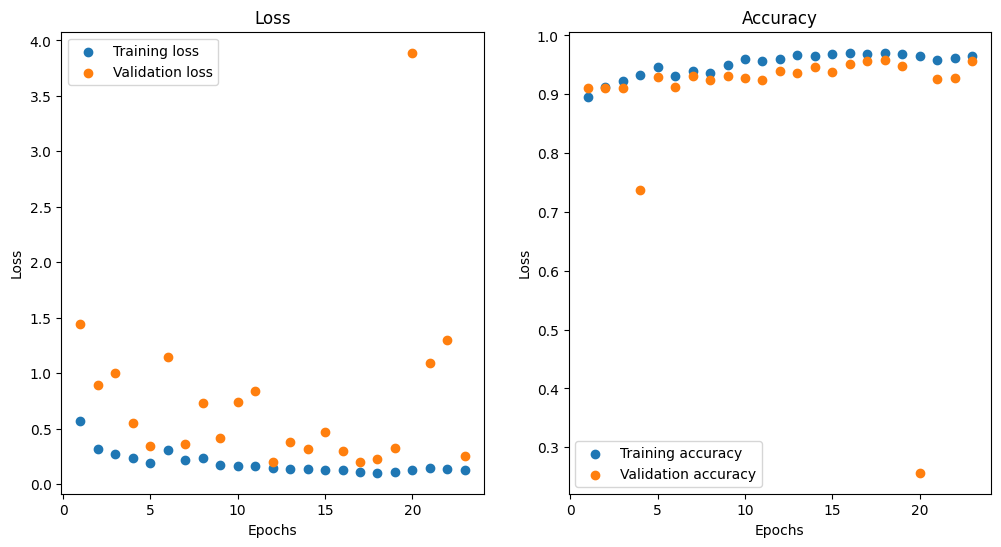

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
epochs = range(1, len(loss) + 1)
axs[0].set_title('Loss')
axs[0].scatter(epochs, loss, label = 'Training loss')
axs[0].scatter(epochs, val_loss, label = 'Validation loss')
axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
accuracy = cnn_history.history['accuracy']
val_accuracy = cnn_history.history['val_accuracy']
axs[1].set_title('Accuracy')
axs[1].scatter(epochs, accuracy, label = 'Training accuracy')
axs[1].scatter(epochs, val_accuracy, label = 'Validation accuracy')
axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')


plt.show()

36/36 [==============================] - 1s 18ms/step
F1 score: 95.4%, accuracy: 95.9%, recall 57.0%


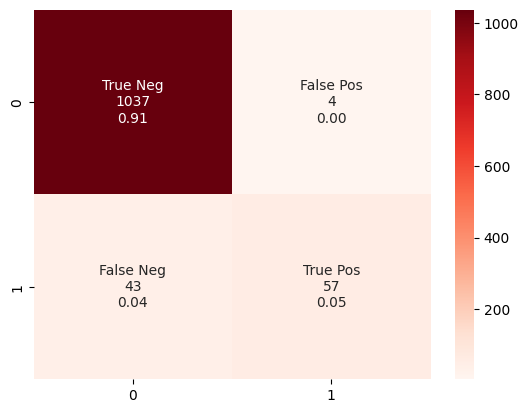

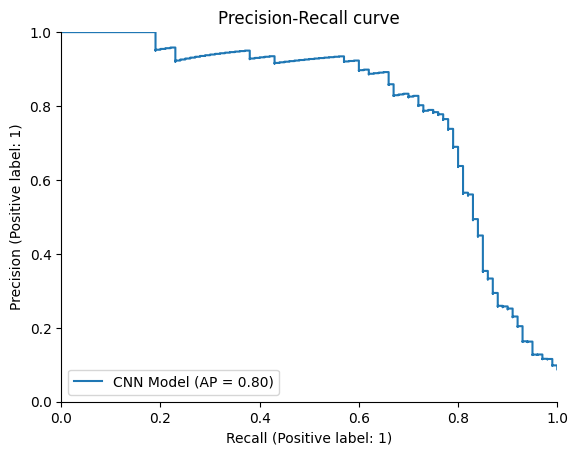

In [15]:

# Evaluate Model:
f1, accuracy, convergence, recall = evaluate_model(cnn_model, cnn_history, X_val, y_val)

# Print the results
print(f"F1 score: {100*f1:.1f}%, accuracy: {100*accuracy:.1f}%, recall {100*recall:.1f}%")

In [16]:
#  Now, let us use features from convolutional network for RF
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

#Make a forward pass through convolutional layers
#This will be a set of features to train RF
X_for_RF = conv_layers.predict(X_train) 

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

84/84 [==============================] - 1s 18ms/step


RandomForestClassifier(n_estimators=50, random_state=42)

36/36 [==============================] - 1s 20ms/step
F1 score: 0.9401
Accuracy: 0.9404
Recall: 0.6500



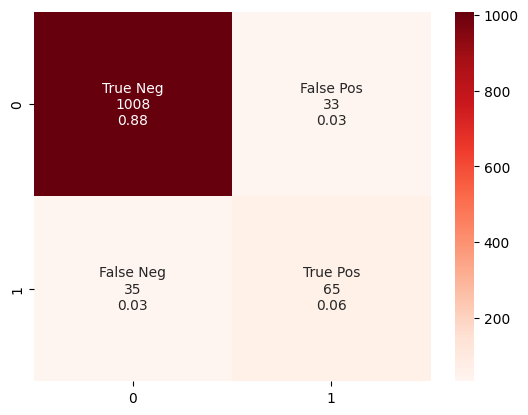

In [17]:
# Evaluate RF model
#Send test data through same feature extractor process
X_test_feature = conv_layers.predict(X_val)

f1, accuracy, recall = evaluate_RF_model(RF_model, X_test_feature, y_val)

# Print the results
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"")

36/36 [==============================] - 1s 19ms/step


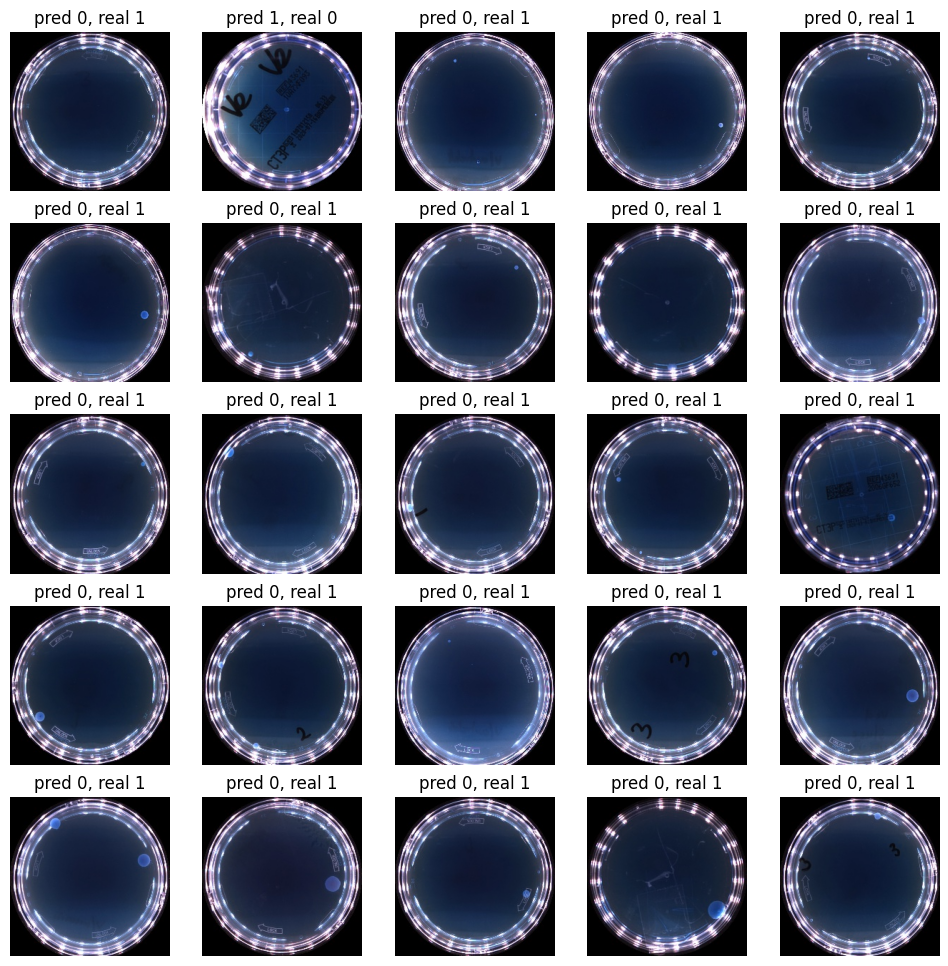

In [18]:
# Visualize 25 mistakes
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(cnn_model.predict(X_val), axis=1)

error_idx = [  i for i, rslt in enumerate(y_true) if (rslt != y_pred[i])  ]


fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    if (5*i+j) < len(error_idx):
        idx = error_idx[5*i+j]
        axs[i,j].imshow(X_val[idx])
        axs[i,j].set_title(f'pred {int(y_pred[idx])}, real {int(y_true[idx])}')
        axs[i,j].axis('off')

plt.show()